## Leaning outcome
1. K-means clustering
2. Anisotropic segmentation
3. Watershed segmentation

# Setup

In [4]:
!pip install requests

In [3]:
import sys
assert sys.version_info >= (3,7)

import numpy as np
import cv2 as cv
from util_func import *

## K-means clustering

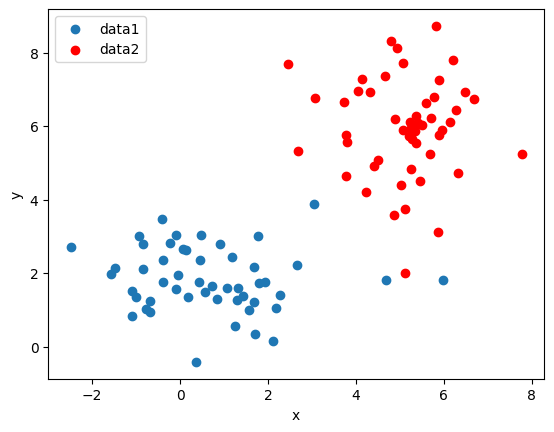

In [7]:
## generate / sample data points from Gaussian probability distribution
# parameters are mean and covariance (2x2 matrix)
np.random.seed()
mean1 = (1, 2)
cov1 = np.array([[2, 0], [0, 1]])
dat1 = np.random.multivariate_normal(mean1, cov1, size=50)

mean2 = (5, 6)
cov2 = np.array([[1, 0],[0, 2]])
dat2 = np.random.multivariate_normal(mean2, cov2, size=50)

# combine them into a dataset
data = np.concatenate((dat1,dat2), axis=0)
Z = np.float32(data)

plt.scatter(dat1[:, 0], dat1[:, 1], label="data1")
plt.scatter(dat2[:, 0], dat2[:, 1], c="r", label="data2")
plt.legend()
plt.xlabel("x"),plt.ylabel("y")
plt.show()

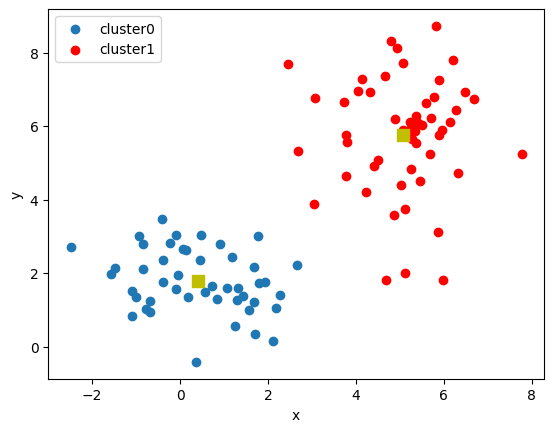

In [13]:
# apply K-means clustering
criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
ret, label, center = cv.kmeans(Z, 2, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)
# ret is WCSOS

# subset the cluster
A = Z[label.flatten() == 0]
B = Z[label.flatten() == 1]

plt.scatter(A[:, 0], A[:, 1], label="cluster0")
plt.scatter(B[:, 0], B[:, 1], c="r", label="cluster1")
plt.scatter(center[:, 0], center[:, 1], c="y", s=80, marker="s")
plt.legend()
plt.xlabel("x"),plt.ylabel("y")
plt.show()

## How to apply k-means clustering on image?
The key is reshape.

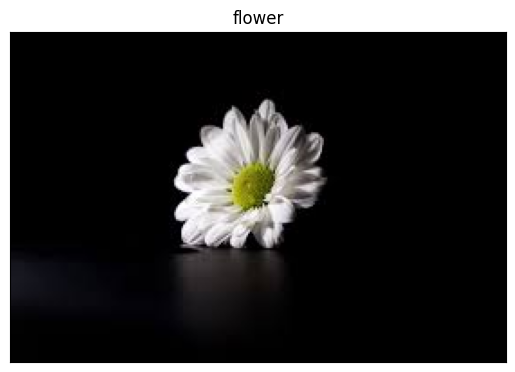

In [20]:
img = cv.imread("images/flower.jfif")
img_rgb= cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt_img(img_rgb, "flower")

In [21]:
def k_means_clust(img, K, max_iter=10, eps=1.0, attempts=10, flag=cv.KMEANS_PP_CENTERS):
    """Args:
    img : 3-channel image array
    K: number of clusters
    By default, max_iter=10, eps=1, attempts=10, k-means++"""
    # casting and reshape
    img = img.reshape((-1, 3))
    img = np.float32(img)
    criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_MAX_ITER, max_iter, eps)
    return cv.kmeans(img, K, None, criteria, attempts, flag)

ret, label, center = k_means_clust(img_rgb, 3)

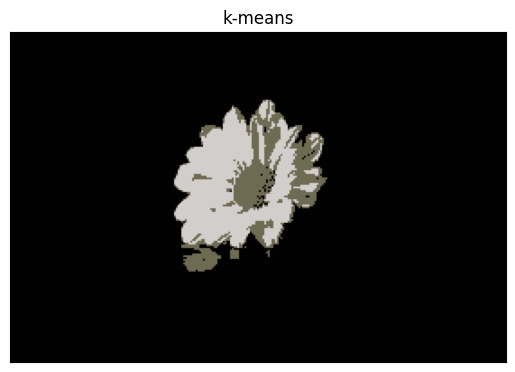

In [48]:
# visualize 
# cast to uint8
center = np.uint8(center)
res = center[label.flatten()]
quant = res.reshape(img_rgb.shape)

plt_img(quant, "k-means")

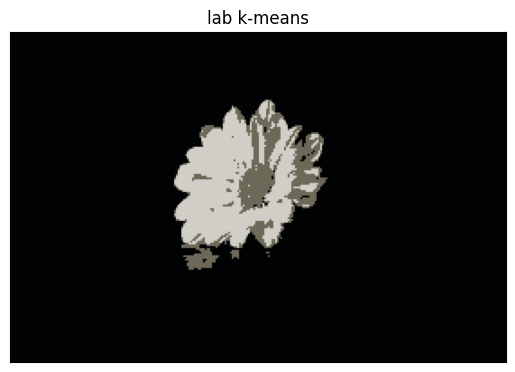

In [49]:
# LAB color space has the property of perceptual uniformity
img_lab = cv.cvtColor(img, cv.COLOR_BGR2Lab)

ret, label, center = k_means_clust(img_lab, 3)

center = np.uint8(center)
res = center[label.flatten()]
quant = res.reshape(img_rgb.shape)

quant_rgb = cv.cvtColor(quant, cv.COLOR_Lab2RGB)

plt_img(quant_rgb, "lab k-means")

In [50]:
np.unique(res, axis=0, return_counts=True)

(array([[  1, 128, 127],
        [113, 126, 138],
        [211, 128, 131]], dtype=uint8),
 array([45419,  1779,  3127], dtype=int64))

In [53]:
# make a bar plot for all the cluster
centroids, counts = np.unique(res, axis=0, return_counts=True)
# change lab to rgb

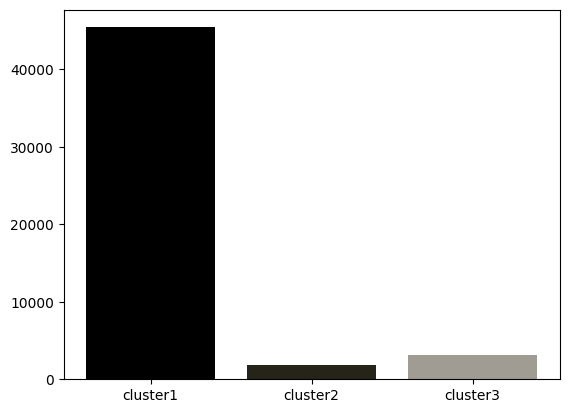

In [57]:
res_rgb = centroids.reshape((3, 1, 3))
res_rgb = cv.cvtColor(res_rgb, cv.COLOR_LAB2LRGB)
res_rgb = res_rgb.reshape((3, 3))

# get the bar plot
xlabel_name = ['cluster' +str(i) for i in range(1, 4)]
plt.bar(xlabel_name, counts, color= list(res_rgb/255))
plt.show()

In [58]:
def calcGST(inputIMG, w):
    img = np.float32(inputIMG)
    
    # Gradient structure tensor components
    if method_edge == "scharr":
        imgDiffX = cv.Scharr(img, cv.CV_32F, 1, 0)
        imgDiffY = cv.Scharr(img, cv.CV_32F, 0, 1)

    elif method_edge == "sobel":
        imgDiffXY = cv.multiply(imgDiffX, imgDiffY)
        imgDiffXX = cv.multiply(imgDiffX, imgDiffX)

    else:
        imgDiffYY = cv.multiply(imgDiffY, imgDiffY)
    
    J11 = cv.boxFilter(imgDiffXX, cv.CV_32F, (w, w))
    J22 = cv.boxFilter(imgDiffYY, cv.CV_32F, (w, w))
    J12 = cv.boxFilter(imgDiffXY, cv.CV_32F, (w, w))
    
    # eigenvalue
    tmp1 = J11+J22
    tmp2 = J11-J22
    tmp2 = cv.multiply(tmp2, tmp2)
    tmp3 = cv.multiply(J12, J12)
    tmp4 = np.sqrt(tmp2 + 4.0*tmp3)
    
    lambda1 = 0.5*(tmp1+tmp4)
    lambda2 = 0.5*(tmp1 - tmp4)
    
    # coherency
    imgCoherencyOut = cv.divide(lambda1-lambda2, lambda1+lambda2)
    
    # orientation calculation
    imgOrientationOut = cv.phase(J22-J11, 2.0*J12, angleInDegrees = True)
    imgOrientationOut = 0.5*imgOrientationOut
    
    return imgCoherencyOut, imgOrientationOut 


The problem of applying Gaussian filter instead of `cv.boxFilter()` line 17 to line 19 is numerical stability (division by zero). The way to remedy this issue is by adding the denominator by a small contant (line 35).

In [59]:
# display and coherency and orientation map
img = cv.imread("images/traffic_sign.jfif")
blur = cv.GaussianBlur(img, (5, 5), 0)
gray = cv.cvtColor(blur, cv.COLOR_BGR2GRAY)

W = 25
imgCoherency, imgOrientation = calcGST(gray, W)

# normalize
imgCoherency_norm = cv.normalize(imgCoherency, None, alpha=0, beta=1, norm_type = cv.NORM_MINMAX, dtype = cv.CV_32F)
imgOrientation_norm = cv.normalize(imgOrientation, None, alpha=0, beta=1, norm_type = cv.NORM_MINMAX, dtype = cv.CV_32F)

plt.subplot(121), plt_img(imgCoherency_norm, "Coherency")
plt.subplot(122), plt_img(imgOrientation_norm, "Orientation")
plt.show()

NameError: name 'method_edge' is not defined

In [61]:
# trackbar function
def nothing(x):
    pass

wn = "anisotropic segmentation"
cv.namedWindow(wn, cv.WINDOW_NORMAL + cv.WINDOW_FREERATIO)
cv.createTrackbar("Coherency Threshold 1", wn, 50, 100, nothing)
cv.createTrackbar("Coherency Threshold 2", wn, 70, 100, nothing)
cv.createTrackbar("Orientation Threshold 1", wn, 50, 180, nothing)
cv.createTrackbar("Orientation Threshold 2", wn, 100, 180, nothing)

while True:
    # get the trackbar positions
    th_C_1 = cv.getTrackbarPos("Coherency Threshold 1", wn) * 0.01
    th_C_2 = cv.getTrackbarPos("Coherency Threshold 2", wn) * 0.01
    th_Or_1 = cv.getTrackbarPos("Orientation Threshold 1", wn)
    th_Or_2 = cv.getTrackbarPos("Orientation Threshold 2", wn)

    # thresholding
    imgBin_c_1 = cv.threshold(imgCoherency, th_C_1, 255, cv.THRESH_BINARY)[1]
    imgBin_c_2 = cv.threshold(imgCoherency, th_C_2, 255, cv.THRESH_BINARY_INV)[1]
    imgBin_Or_1 = cv.threshold(imgOrientation, th_Or_1, 255, cv.THRESH_BINARY)[1]
    imgBin_Or_2 = cv.threshold(imgOrientation, th_Or_2, 255, cv.THRESH_BINARY)[1]

    imgBin_C = cv.bitwise_and(imgBin_C_1, imgBin_C_2)
    imgBin_Or = cv.bitwise_and(imgBin_Or_1, imgBin_Or_2)

    imgBin = cv.bitwise_and(imgBin_C, imgBin_Or)

    mask = imgBin != 0
    res = img*(mask[:, :, None].dtype(np.uint8))
    cv.imshow(wn, res)
    cv.imshow("segmentation mask", imgBin)
    k = cv.WaitKey(1) & 0xFF
    if k==27:
        break

cv.destroyAllWindows()

NameError: name 'imgCoherency' is not defined

## Watershed
Topographic surface: edge map
marker: morphological gradient + threshold

In [5]:
pip install scikit-image

  Obtaining dependency information for scikit-image from https://files.pythonhosted.org/packages/08/c0/8085c5fd2f7f7514a0c5031b666171d5828ac5b3c9cf5d0ecd19688d5407/scikit_image-0.21.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for scipy>=1.8 from https://files.pythonhosted.org/packages/04/b8/947f40706ee2e316fd1a191688f690c4c2b351c2d043fe9deb9b7940e36e/scipy-1.11.1-cp311-cp311-win_amd64.whl.metadata
     ---------------------------------------- 0.0/59.1 kB ? eta -:--:--
     ---------------------------------- ----- 51.2/59.1 kB 1.3 MB/s eta 0:00:01
     ---------------------------------- ----- 51.2/59.1 kB 1.3 MB/s eta 0:00:01
     -------------------------------------- 59.1/59.1 kB 444.6 kB/s eta 0:00:00
     ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
     -- ------------------------------------- 0.1/2.1 MB 3.3 MB/s eta 0:00:01
     --- ------------------------------------ 0.2/2.1 MB 2.4 MB/s eta 0:00:01
     ----- ---------------------

In [6]:
from skimage.segmentation import watershed
from scipy import ndimage as ndi

In [4]:
# boad image
img = cv.imread("images/traffic_sign.jfif")
blur = cv.GaussianBlur(img, (5, 5), 0)
blur = cv.pyrMeanShiftFiltering(blur, 15, 20, maxLevel=2)

show_img("blur", blur)

In [7]:
# grayscale
gray = cv.cvtColor(blur, cv.COLOR_BGR2GRAY)

# morphological gradient
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (11, 11))
loc_grad = cv.morphologyEx(gray, cv.MORPH_GRADIENT, kernel, iterations=2)

show_img("gradient",loc_grad)

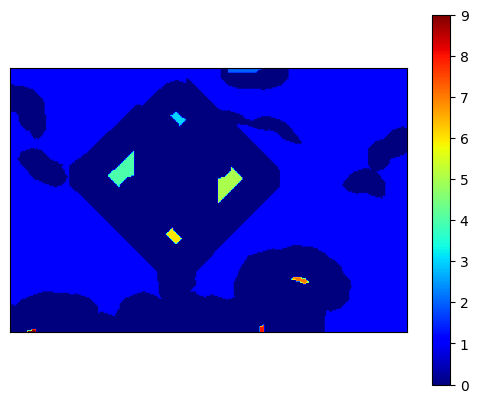

In [8]:
th = loc_grad < 80
# connected component labeling
s = np.ones((3, 3), dtype = int)
marker = ndi.label(th, structure=s)[0]

plt.imshow(marker, cmap=plt.cm.jet)
plt.colorbar()
plt.xticks([]), plt.yticks([])
plt.show()

In [9]:
edge = cv.Canny(gray, 250, 500)
labels = watershed(edge, marker)

In [10]:
np.unique(labels, return_counts= True)

(array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([40736,   279,  1234,  2325,  2295,  1270,  1066,   736,   384],
       dtype=int64))

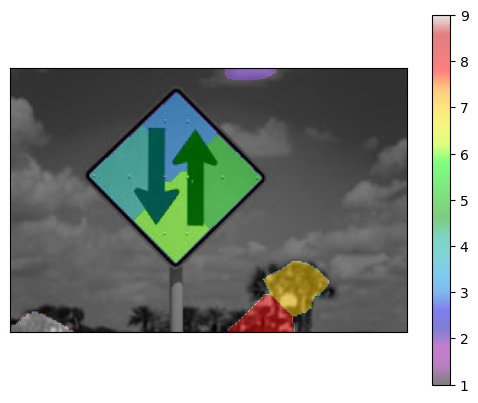

In [11]:
gray_ori = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

plt.imshow(gray_ori, cmap="gray")
plt.imshow(labels, cmap=plt.cm.nipy_spectral, alpha=0.5)
plt.colorbar()
plt.xticks([]), plt.yticks([])
plt.show()

In [12]:
# create mask/ binary img and set the background to zero.
# Assumption: background is always the majority
mask = 255 * np.ones(labels.shape, dtype= np.uint8)

label_vec, counts = np.unique(labels, return_counts= True)
label_bg = label_vec[np.argmax(counts)]

mask[labels==label_bg] = 0

# contours 
contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# grab the largest contour
contour = sorted(contours, key=cv.contourArea, reverse=True)[0]

img_copy = img.copy()
cv.drawContours(img_copy, [contour], -1, (0, 255, 0), 2)

show_img("container", img_copy)

In [14]:
# bounding box
img_copy = img.copy()
x, y, w, h = cv.boundingRect(contour)
cv.rectangle(img_copy, (x, y), (x+w, y+h), (0, 255, 0), 2)

show_img("bounding box", img_copy)

In [15]:
gray = cv.cvtColor(bgr, cv.COLOR_BGR2GRAY)

th = cv.threshold(gray, 0, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)[1]

show_img("threshold", th)

NameError: name 'bgr' is not defined

In [17]:
img = cv.imread("images/traffic_sign1.jpg")
(h, w) = img.shape[:2]
blur = cv.GaussianBlur(img, (5, 5), 0)

In [18]:
# Convert to Lab
img_lab = cv.cvtColor(blur, cv.COLOR_BGR2Lab)

img_lab = img_lab.reshape((h*w, 3))
img_lab = np.float32(img_lab)
# criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
flags = cv.KMEANS_PP_CENTERS

compactness, labels, centers = cv.kmeans(img_lab, 10, None, criteria, 10, flags)

quant = centers.astype(np.uint8)[labels]
quant = quant.reshape((h, w, 3))

bgr = cv.cvtColor(quant, cv.COLOR_Lab2BGR)

show_img("kmeans quantization", bgr)

In [19]:
img_lab[..., 0].min()

6.0

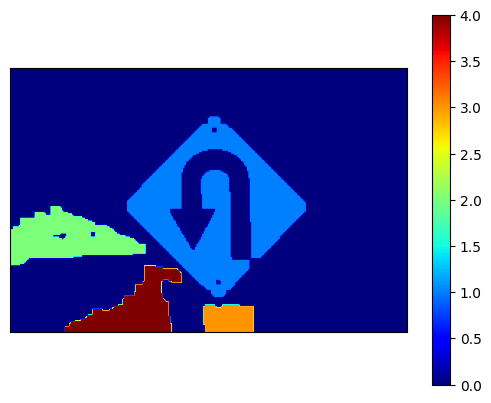

In [21]:
gray = cv.cvtColor(bgr, cv.COLOR_BGR2GRAY)

th = cv.threshold(gray, 0, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)[1]

show_img("threshold", th)
from skimage.feature import peak_local_max
kernel = np.ones((3, 3), dtype=np.uint8)
th = cv.morphologyEx(th, cv.MORPH_OPEN, kernel, iterations=3)

dist_transform = cv.distanceTransform(th, cv.DIST_L2, 3)

coords = peak_local_max(dist_transform, footprint=np.ones((100, 100)), labels=th)

mask = np.zeros(dist_transform.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
labels = watershed(-dist_transform, markers, mask=th)
plt.imshow(labels, cmap=plt.cm.jet)
plt.colorbar(), plt.xticks([]), plt.yticks([])
plt.show()

## Weekly activity
1. Apply k-means clustering on 'zebra.jfif' to segment out the zebra.
     - You are required to determine the optimal k by plotting the within cluster sum of squares vs number of clusters (2-10).
     - Apply the clustering method on 3 color spaces: BGR, HSV and LAB. Compare the results obtained.

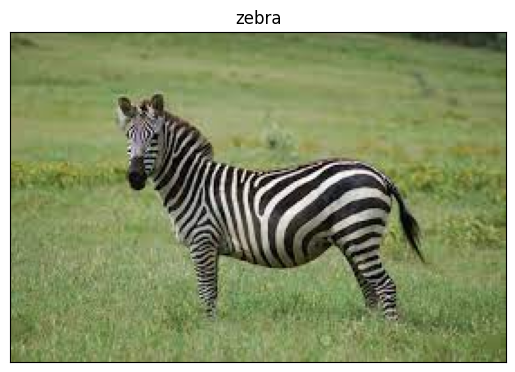

In [22]:
img = cv.imread("images/zebra.jfif")
img_rgb= cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt_img(img_rgb, "zebra")

ret, label, center = k_means_clust(img_rgb, 3)



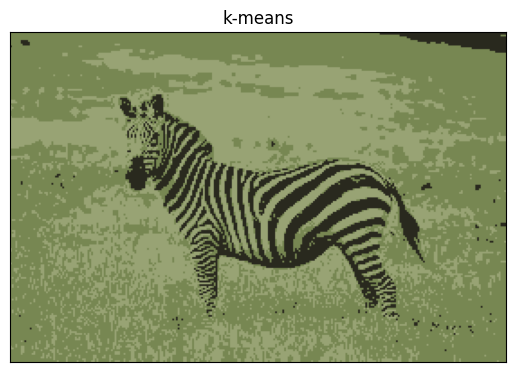

In [23]:
# visualize 
# cast to uint8
center = np.uint8(center)
res = center[label.flatten()]
quant = res.reshape(img_rgb.shape)

plt_img(quant, "k-means")

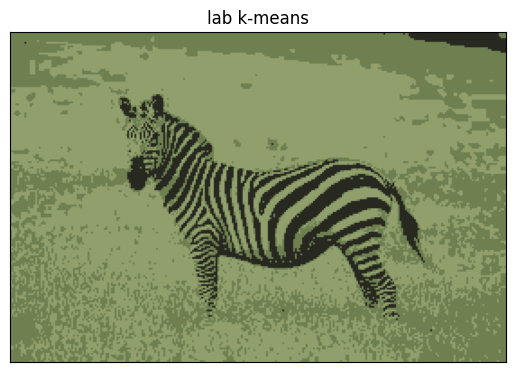

In [24]:
# LAB color space has the property of perceptual uniformity
img_lab = cv.cvtColor(img, cv.COLOR_BGR2Lab)

ret, label, center = k_means_clust(img_lab, 3)

center = np.uint8(center)
res = center[label.flatten()]
quant = res.reshape(img_rgb.shape)

quant_rgb = cv.cvtColor(quant, cv.COLOR_Lab2RGB)

plt_img(quant_rgb, "lab k-means")